In [1]:
#Dataset will be shared through drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [2]:
import collections
import pickle

import matplotlib
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold

#Utilities

In [5]:
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f, encoding="latin1")  # add, encoding="latin1") if using python3 and downloaded data

# BERT-base Attention Maps extracted from Wikipedia
# Data is a list of dicts of the followig form:
# {
#    "tokens": list of strings
#    "attns": [n_layers, n_heads, n_tokens, n_tokens] 
#             tensor of attention weights
# }
data = load_pickle("/content/gdrive/My Drive/unlabeled_attn.pkl")
n_docs = len(data)

# Average Jenson-Shannon divergences between attention heads
js_divergences = load_pickle("/content/gdrive/My Drive/head_distances.pkl")


def data_iterator():
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"])

In [10]:
#colours for plots
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [11]:
#getting data for plots
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

#1. Attention maps for Figures 1 - 3

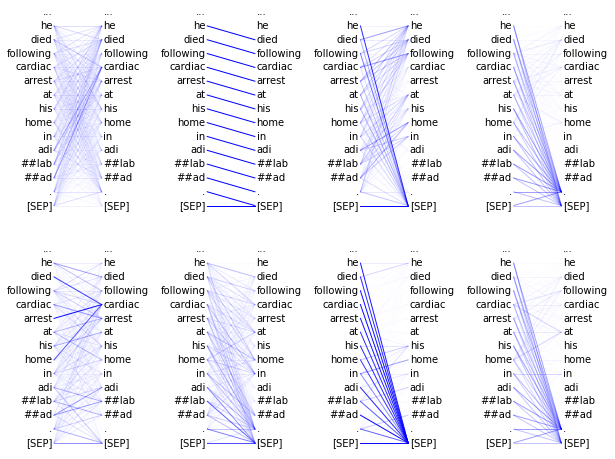

In [30]:
#attention maps for Figure 1
width = 3
example_sep = 3
word_height = 1
pad = 0.1


def plot_attn(ax,example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attns"][layer][head][-15:, -15:]
    attn = np.array(attn)
    attn /= attn.sum(axis=-1, keepdims=True)
    words = example["tokens"][-15:]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      ax.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      ax.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        ax.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color="blue", linewidth=1, alpha=attn[i, j])


plt.figure(figsize=(10, 8))
ax = plt.subplot(2, 1, 1)
ax.axis("off")
plot_attn(ax,data[325], [(0, 0), (2, 0), (7, 0), (11, 0)]) #325th segment #(layers, head)
ax = plt.subplot(2, 1, 2)
ax.axis("off")
plot_attn(ax,data[325], [(0, 11), (2,11), (7, 11), (11, 11)])
plt.show()

#2a. Average attention

In [13]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls"]
}

print("Computing token stats")
for tokens, attns in data_iterator():
  n_tokens = attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1

  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    avg_attns[key] += (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom))

Computing token stats
0.1% done
10.2% done
20.3% done
30.3% done
40.4% done
50.5% done
60.6% done
70.7% done
80.7% done
90.8% done
100.0% done


#2b. Plotting average attention - Figure 4

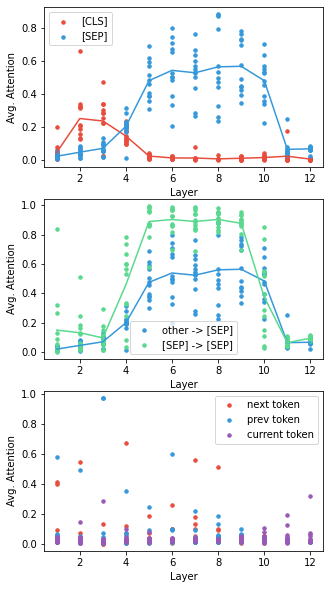

In [32]:
def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    ("sep_sep", GREEN, "[SEP] -> [SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
  add_line(key, ax, color, label, plot_avgs=False)

plt.show()

#3. Average entropy

In [33]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

print("Computing entropy stats")
for tokens, attns in data_iterator():
  attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
  uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
  entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
  entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

Computing entropy stats
0.1% done
10.2% done
20.3% done
30.3% done
40.4% done
50.5% done
60.6% done
70.7% done
80.7% done
90.8% done
100.0% done


#3b. Plotting average entropy - Figure 5

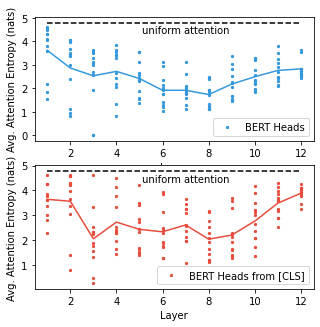

In [34]:
xs, es, avg_es = get_data_points(entropies)
xs, es_cls, avg_es_cls = get_data_points(entropies_cls)

plt.figure(figsize=(5, 5))

def plot_entropies(ax, data, avgs, label, c):
  ax.scatter(xs, data, c=c, s=5, label=label)
  ax.plot(1 + np.arange(12), avgs, c=c)
  ax.plot([1, 12], [uniform_attn_entropy, uniform_attn_entropy],
          c="k", linestyle="--")
  ax.text(7, uniform_attn_entropy - 0.45, "uniform attention",
          ha="center")
  ax.legend(loc="lower right")
  ax.set_ylabel("Avg. Attention Entropy (nats)")
  ax.set_xlabel("Layer")

plot_entropies(plt.subplot(2, 1, 1), es, avg_es, "BERT Heads",
               c=BLUE)
plot_entropies(plt.subplot(2, 1, 2), es_cls, avg_es_cls,
               "BERT Heads from [CLS]", c=RED)

plt.show()

#Semantic learning in individual heads

In [48]:
def load_pickle(fname):
  with open(fname, "rb") as f:
    return pickle.load(f, encoding="latin1")
    
dev_data = load_pickle("/content/gdrive/My Drive/dev_attn.pkl")

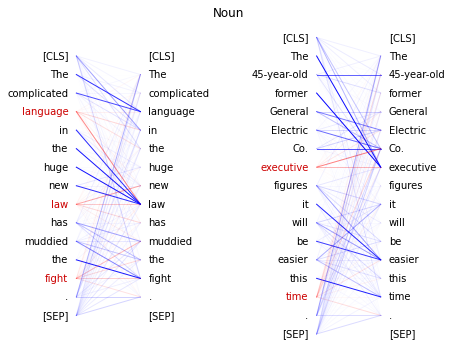

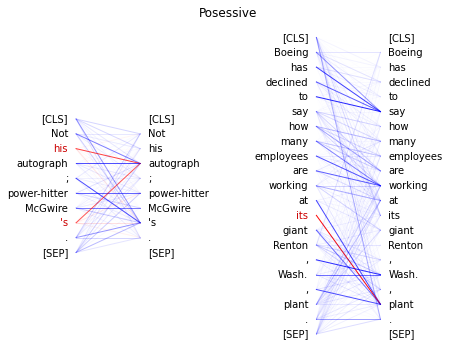

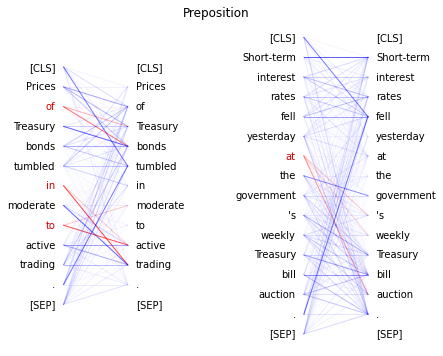

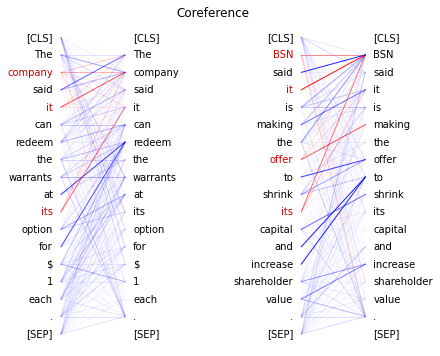

In [74]:
def plot_attn(title, examples, layer, head, color_words,
              color_from=True, width=1, example_sep=3, 
              word_height=1, pad=0.1, hide_sep=False):
  """Plot BERT's attention for a particular head/example."""
  plt.figure(figsize=(6, 6))
  for i, example in enumerate(examples):
    yoffset = 0
    if i == 0:
      yoffset += (len(examples[0]["words"]) -
                  len(examples[1]["words"])) * word_height / 2
    xoffset = i * width * example_sep
    attn = example["attns"][layer][head]
    if hide_sep:
      attn = np.array(attn)
      attn[:, 0] = 0
      attn[:, -1] = 0
      attn /= attn.sum(axis=-1, keepdims=True)

    words = ["[CLS]"] + example["words"] + ["[SEP]"]
    n_words = len(words)
    for position, word in enumerate(words):
      for x, from_word in [(xoffset, True), (xoffset + width, False)]:
        color = "k"
        if from_word == color_from and word in color_words:
          color = "#cc0000"
        plt.text(x, yoffset - (position * word_height), word,
                 ha="right" if from_word else "left", va="center",
                 color=color)

    for i in range(n_words):
      for j in range(n_words):
        color = "b"
        if words[i if color_from else j] in color_words:
          color = "r"
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=1, alpha=attn[i, j])
  plt.axis("off")
  plt.title(title)
  plt.show()

plot_attn("Noun", [dev_data[13], dev_data[1671]], 7, 10, 
          ["language", "law", "fight", "time", "executive"], hide_sep=True)
plot_attn("Posessive", [dev_data[111], dev_data[244]], 6, 5,
          ["his", "'s", "its"], hide_sep=True)
plot_attn("Preposition", [dev_data[975],dev_data[979]], 8, 5,
          ["in", "with", "to", "of", "at"], hide_sep=True)
plot_attn("Coreference", [dev_data[401],dev_data[403]], 6, 10,
          ["company", "BSN", "its", "it", "offer"], hide_sep=True)

#Not so good heads

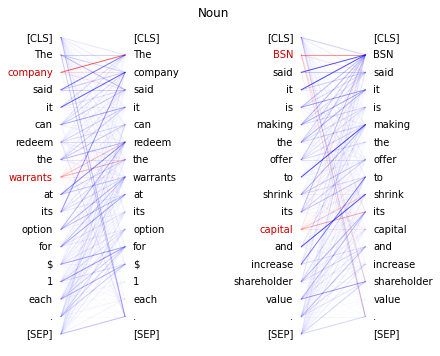

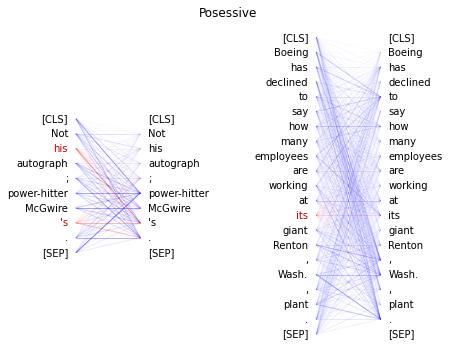

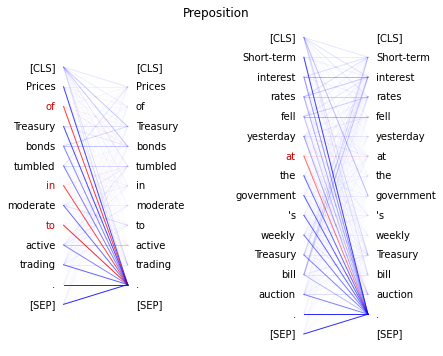

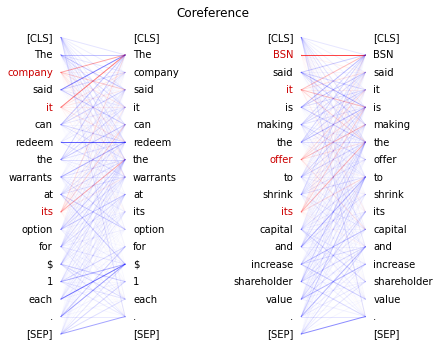

In [58]:
def plot_attn(title, examples, layer, head, color_words,
              color_from=True, width=1, example_sep=3, 
              word_height=1, pad=0.1, hide_sep=False):
  """Plot BERT's attention for a particular head/example."""
  plt.figure(figsize=(6, 6))
  for i, example in enumerate(examples):
    yoffset = 0
    if i == 0:
      yoffset += (len(examples[0]["words"]) -
                  len(examples[1]["words"])) * word_height / 2
    xoffset = i * width * example_sep
    attn = example["attns"][layer][head]
    if hide_sep:
      attn = np.array(attn)
      attn[:, 0] = 0
      attn[:, -1] = 0
      attn /= attn.sum(axis=-1, keepdims=True)

    words = ["[CLS]"] + example["words"] + ["[SEP]"]
    n_words = len(words)
    for position, word in enumerate(words):
      for x, from_word in [(xoffset, True), (xoffset + width, False)]:
        color = "k"
        if from_word == color_from and word in color_words:
          color = "#cc0000"
        plt.text(x, yoffset - (position * word_height), word,
                 ha="right" if from_word else "left", va="center",
                 color=color)

    for i in range(n_words):
      for j in range(n_words):
        color = "b"
        if words[i if color_from else j] in color_words:
          color = "r"
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=1, alpha=attn[i, j])
  plt.axis("off")
  plt.title(title)
  plt.show()

plot_attn("Noun", [dev_data[401], dev_data[403]], 4, 10, 
          ["company", "BSN", "warrants", "capital"], hide_sep=True)
plot_attn("Posessive", [dev_data[111], dev_data[244]], 2, 5,
          ["his", "'s", "its"], hide_sep=True)
plot_attn("Preposition", [dev_data[975],dev_data[979]], 11, 5,
          ["in", "with", "to", "of", "at"], hide_sep=True)
plot_attn("Coreference", [dev_data[401],dev_data[403]], 1, 10,
          ["company", "BSN", "its", "it", "offer"], hide_sep=True)

#Clustering heads based on their attention maps

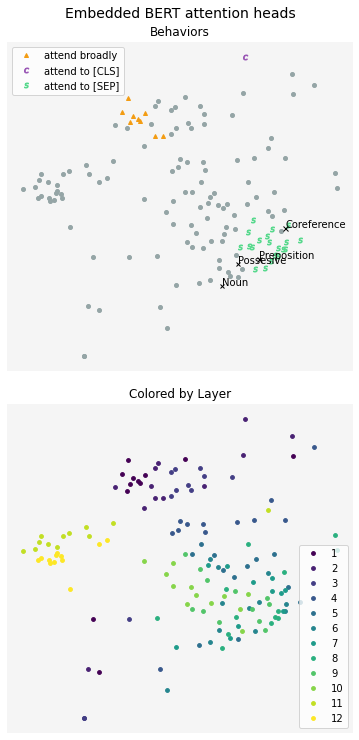

In [61]:
ENTROPY_THRESHOLD = 4.0  # When to say a head "attends broadly"
POSITION_THRESHOLD = 0.6  # When to say a head "attends to next/prev"
SPECIAL_TOKEN_THRESHOLD = 0.6  # When to say a heads attends to [CLS]/[SEP]"
# Heads that were found to have linguistic behaviors
LINGUISTIC_HEADS = {
    (6, 10): "Coreference",
    (7, 10): "Noun",
    (8, 5): "Preposition",
    (6, 5): "Possesive",
}

mds = sklearn.manifold.MDS(metric=True, n_init=5, n_jobs=4, eps=1e-10,
                           max_iter=1000, dissimilarity="precomputed")
pts = mds.fit_transform(js_divergences)
pts = pts.reshape((12, 12, 2))
pts_flat = pts.reshape([144, 2])

colormap = cm.viridis(np.linspace(0, 1.0, 12)) #cm.seismic(np.linspace(0, 1.0, 12))
plt.figure(figsize=(4.8, 9.6))
plt.title("BERT Attention Heads")

for color_by_layer in [False, True]:
  ax = plt.subplot(2, 1, int(color_by_layer) + 1)
  seen_labels = set()
  for layer in range(12):
    for head in range(12):
      label = ""
      color = GREY
      marker = "o"
      markersize = 4
      x, y = pts[layer, head]

      if entropies[layer, head] > ENTROPY_THRESHOLD:
        color = ORANGE
        label = "attend broadly"
        marker = "^"

      if avg_attns["cls"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = PURPLE
        label = "attend to [CLS]"
        marker = "$C$"
        markersize = 5

      if avg_attns["sep"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = GREEN
        marker = "$S$"
        markersize = 5
        label = "attend to [SEP]"

      if color_by_layer:
        label = str(layer + 1)
        color = colormap[layer]
        marker = "o"
        markersize = 3.8

      if not color_by_layer:
        if (layer, head) in LINGUISTIC_HEADS:
          label = ""
          color = BLACK
          marker = "x"
          ax.text(x, y, LINGUISTIC_HEADS[(layer, head)], color=color)

      if label not in seen_labels:
        seen_labels.add(label)
      else:
        label = ""

      ax.plot([x], [y], marker=marker, markersize=markersize,
              color=color, label=label, linestyle="")

  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.set_facecolor((0.96, 0.96, 0.96))
  plt.title(("Colored by Layer" if color_by_layer else "Behaviors"))
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels, loc="best")

plt.suptitle("Embedded BERT attention heads", fontsize=14, y=1.05)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0.1, wspace=0)
plt.show()